## Import necessary libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import re
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

nltk.download(['punkt', 'stopwords', 'wordnet', 'averaged_perceptron_tagger'])

sns.set_style("darkgrid")

[nltk_data] Downloading package punkt to /home/nabanita/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nabanita/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nabanita/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/nabanita/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Exploratory Data Analysis

Let's load the data and look at few entries.

In [2]:
df = pd.read_csv("listings.csv")
df.head()

,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),-1,True
1,1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,-1
2,2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,GoDaddy,-1
3,3,Data Analyst,$37K-$66K (Glassdoor est.),Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),-1,-1
4,4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),DraftKings,True


In [3]:
# drop the column 'Unnamed: 0'
del df["Unnamed: 0"]

In [4]:
print("The shape of our dataframe is : {}".format(df.shape))

The shape of our dataframe is : (2253, 15)


What are the types of different features present in the dataset?

In [6]:
df.dtypes

Job Title             object
Salary Estimate       object
Job Description       object
Rating               float64
Company Name          object
Location              object
Headquarters          object
Size                  object
Founded                int64
Type of ownership     object
Industry              object
Sector                object
Revenue               object
Competitors           object
Easy Apply            object
dtype: object

Except 'Rating' and 'Founded' all other features are defined as 'object' type. Let's find out how many columns have null values.

In [5]:
df.isnull().sum()

Job Title            0
Salary Estimate      0
Job Description      0
Rating               0
Company Name         1
Location             0
Headquarters         0
Size                 0
Founded              0
Type of ownership    0
Industry             0
Sector               0
Revenue              0
Competitors          0
Easy Apply           0
dtype: int64

Only the column 'Company Name' has one missing value. But when we look at the data closely, we find that there are some entries like '-1',-1, 'Unknown' in the dataframe. These values are equivalent to NaNs. An easy way to find this out is to look at the unique elements in each column. 

In [7]:
# number of unique elements in each column
df.nunique()

Job Title            1272
Salary Estimate        90
Job Description      2253
Rating                 37
Company Name         1513
Location              253
Headquarters          483
Size                    9
Founded               161
Type of ownership      15
Industry               89
Sector                 25
Revenue                14
Competitors           291
Easy Apply              2
dtype: int64

Let's look at unique values in some of these columns.

In [8]:
df['Rating'].unique()

array([ 3.2,  3.8,  3.4,  4.1,  3.9,  4.4,  3.7,  4. , -1. ,  3. ,  3.6,
        4.9,  3.3,  3.5,  5. ,  4.8,  4.7,  4.6,  2.9,  1. ,  3.1,  4.5,
        2.3,  4.2,  2.8,  4.3,  2.7,  2.5,  2.6,  2.4,  2. ,  2.1,  1.7,
        2.2,  1.8,  1.6,  1.9])

In [9]:
df['Size'].unique()

array(['201 to 500 employees', '10000+ employees',
       '1001 to 5000 employees', '501 to 1000 employees',
       '5001 to 10000 employees', '1 to 50 employees',
       '51 to 200 employees', 'Unknown', '-1'], dtype=object)

So, we replace all these above mentioned entries by NaNs.

In [10]:
df.replace([-1.,-1, '-1', 'Unknown', 'Unknown / Non-Applicable'], np.nan, inplace=True)

In [11]:
# check our dataframe after the replacement
df.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961.0,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),NaN,True
1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893.0,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),NaN,NaN
2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003.0,Company - Private,Internet,Information Technology,NaN,GoDaddy,NaN
3,Data Analyst,$37K-$66K (Glassdoor est.),Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002.0,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),NaN,NaN
4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009.0,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),DraftKings,True


After this replacement, we check again the number of null values in each of the features.

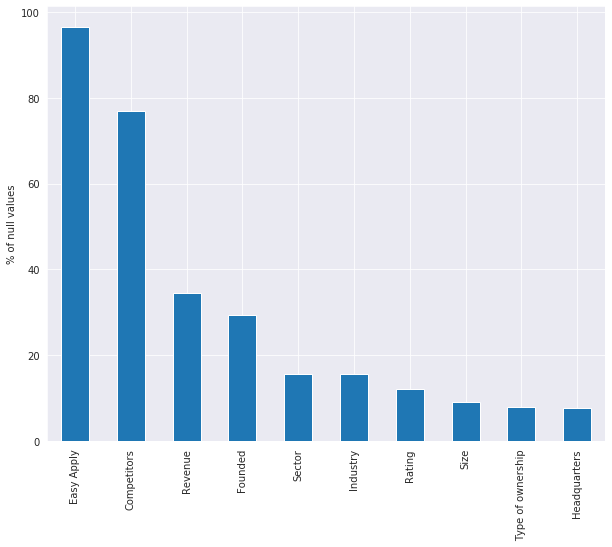

In [12]:
# calculate % of null value in each column and sort them in descending order
null_percentage = df.isnull().sum().sort_values(ascending=False)/len(df)*100

# make a plot
null_percentage[null_percentage>0.1].plot(kind='bar', figsize=(10,8))
plt.ylabel("% of null values");

As we can see from the above plot, most of the entries in 'Easy Apply' and 'Competitors' are missing. Therefore, we will drop these two columns. 

In [13]:
df.drop(['Easy Apply', 'Competitors'], axis=1, inplace=True)
print("The shape of the dataframe after dropping features : {}".format(df.shape))

The shape of the dataframe after dropping features : (2253, 13)


Let's now calculate null value percentage in each row of the dataframe.

In [14]:
# calculate % of null value in each row and sort them in descending order
row_null_percentage = df.isnull().sum(axis=1).sort_values(ascending=False)/len(df)*100
row_null_percentage

1860    0.399467
1168    0.355082
1459    0.355082
1940    0.355082
253     0.355082
          ...   
1284    0.000000
1288    0.000000
1289    0.000000
1291    0.000000
0       0.000000
Length: 2253, dtype: float64

None of the row has significant amount of null values and therefore no row can be dropped on the basis of null value percentage. 

The first question that one can ask is that **which industries are hiring data analysts actively at present?** 

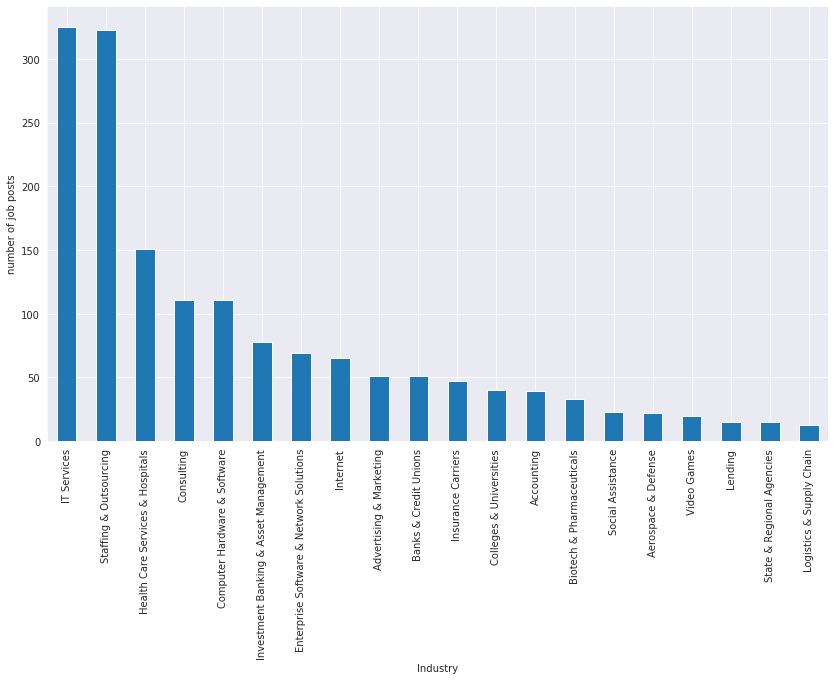

In [16]:
df['Industry'].value_counts()[:20].plot(kind='bar', figsize=(14,8))
plt.xlabel("Industry")
plt.ylabel("number of job posts");

Most of the data analyst job posts are in the IT and Staffing & Outsourcing sectors. Current data analyst post vacancy in the Health Care sector is almost half of these two.

The next interesting question could be **What is the distribution of salary across all the industries?** Let's look at the column 'Salary Estimate'.

In [17]:
# first 10 entries in 'Salary Estimate'
df['Salary Estimate'][:10]

0    $37K-$66K (Glassdoor est.)
1    $37K-$66K (Glassdoor est.)
2    $37K-$66K (Glassdoor est.)
3    $37K-$66K (Glassdoor est.)
4    $37K-$66K (Glassdoor est.)
5    $37K-$66K (Glassdoor est.)
6    $37K-$66K (Glassdoor est.)
7    $37K-$66K (Glassdoor est.)
8    $37K-$66K (Glassdoor est.)
9    $37K-$66K (Glassdoor est.)
Name: Salary Estimate, dtype: object

We need to clean this. We create three new features from this column - minimum, maximum and average salaries offered in different industries and then drop the original feature.

In [18]:
# the minimum salary offered
df['min_salary'] = df['Salary Estimate'].apply(lambda x:float(x.split()[0].split("-")[0].strip("$,K")) 
                                                          if not pd.isnull(x) else x)

# the maximum salary offered
df['max_salary'] = df['Salary Estimate'].apply(lambda x:float(x.split()[0].split("-")[1].strip("$,K")) 
                                                          if not pd.isnull(x) else x)

# the average salary offered
df['avg_salary'] = (df['min_salary'] + df['max_salary'])/2.

In [19]:
# drop the original column
df.drop('Salary Estimate', axis=1, inplace=True)

In [14]:
#find_str = 'analyst'
#df['Job Title'] = df['Job Title'].apply(lambda x:x[:(x.lower()).find(find_str)+len(find_str)].lower())

Now we can look at the distribution of average salary in different industries.

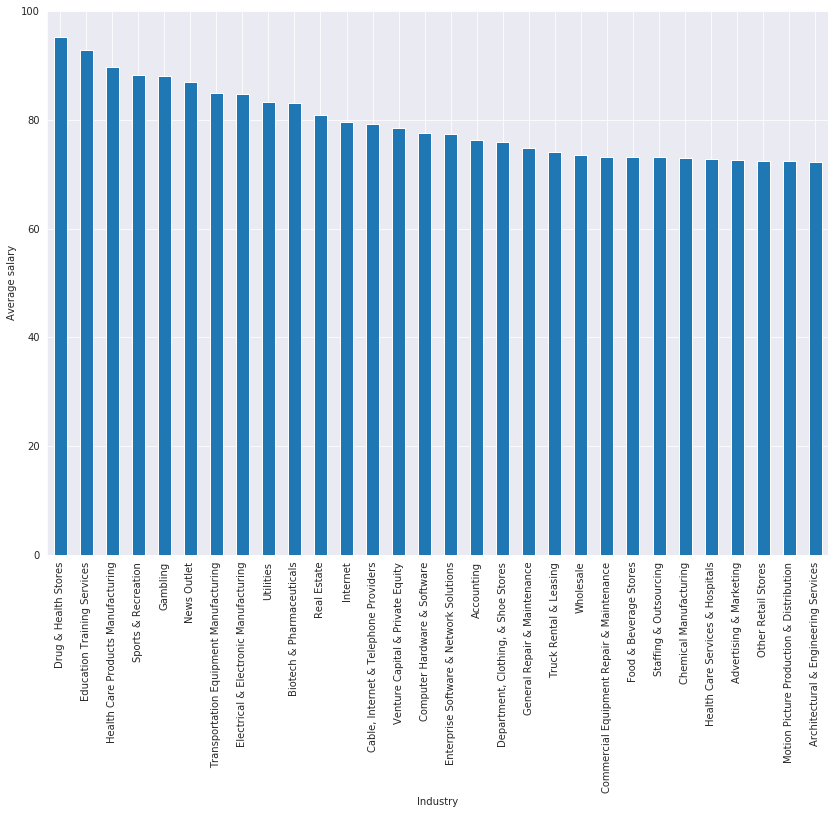

In [20]:
# plot top 30 industries with highest offered salaries
df.groupby('Industry')['avg_salary'].mean().sort_values(ascending=False)[:30].plot(kind='bar', figsize=(14,10))
plt.xlabel('Industry')
plt.ylabel('Average salary');

This is interesting! Although IT sector has maximum number of job postings, the salary offered does not fall into top 30. The healthcare industry ('Drug & Health Stores', 'Health Care Products Manufacturing', 'Biotech & Pharmaceuticals', 'Health Care Services & Hospitals') generally has a high average salary. The average salary offered in education industry is almost comparable to that of healthcare industry. This plot tells us that even if some industries have fewer job postings, they offer better salaries.

**Which companies are hiring data analysts actively?** Let's look at the column 'Company Name'.

In [21]:
df['Company Name'].unique()[:20]

array(['Vera Institute of Justice\n3.2',
       'Visiting Nurse Service of New York\n3.8', 'Squarespace\n3.4',
       'Celerity\n4.1', 'FanDuel\n3.9', 'Point72\n3.9', 'Two Sigma\n4.4',
       'GNY Insurance Companies\n3.7', 'DMGT\n4.0', 'Riskified\n4.4',
       'NYU Langone Health\n4.0', 'BulbHead', 'Montefiore Medical\n3.7',
       'Known\n3.0', 'Advisor Group\n3.4', 'CodeGreen Solutions\n3.6',
       'Undertone\n3.8', 'NYSTEC\n3.8',
       'Education Development Center, Inc.\n3.9',
       'Teachers Pay Teachers\n4.9'], dtype=object)

In [22]:
# extract only the company name
df['Company Name'] = df['Company Name'].apply(lambda x:x.split("\n")[0].strip() 
                                                       if not pd.isnull(x) else x)

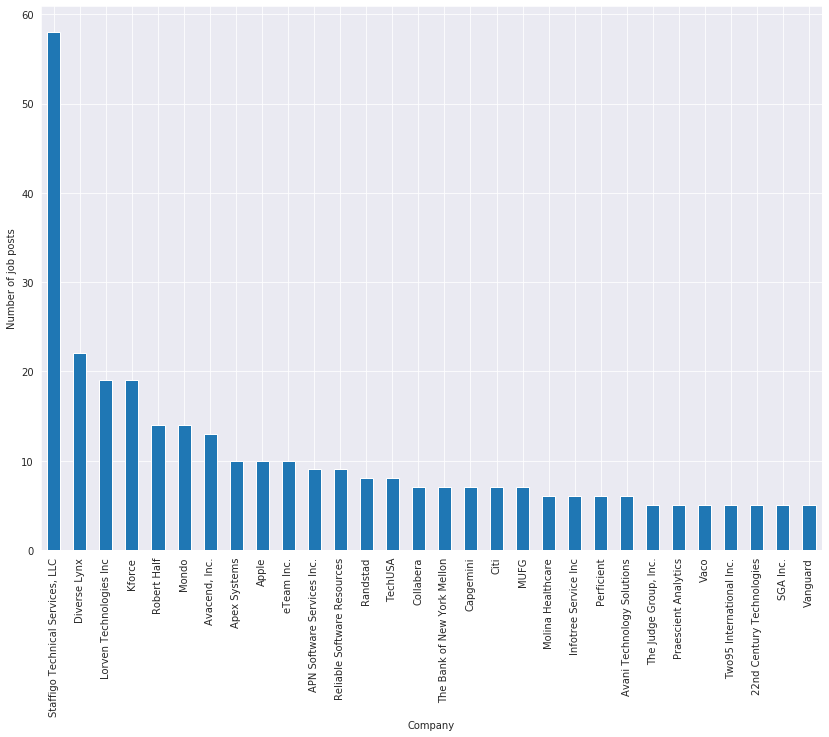

In [27]:
# plot top 30 companies with high job postings
df['Company Name'].value_counts()[:30].plot(kind='bar', figsize=(14,10))
plt.xlabel('Company')
plt.ylabel('Number of job posts');

**Which companies are offering high salaries?**

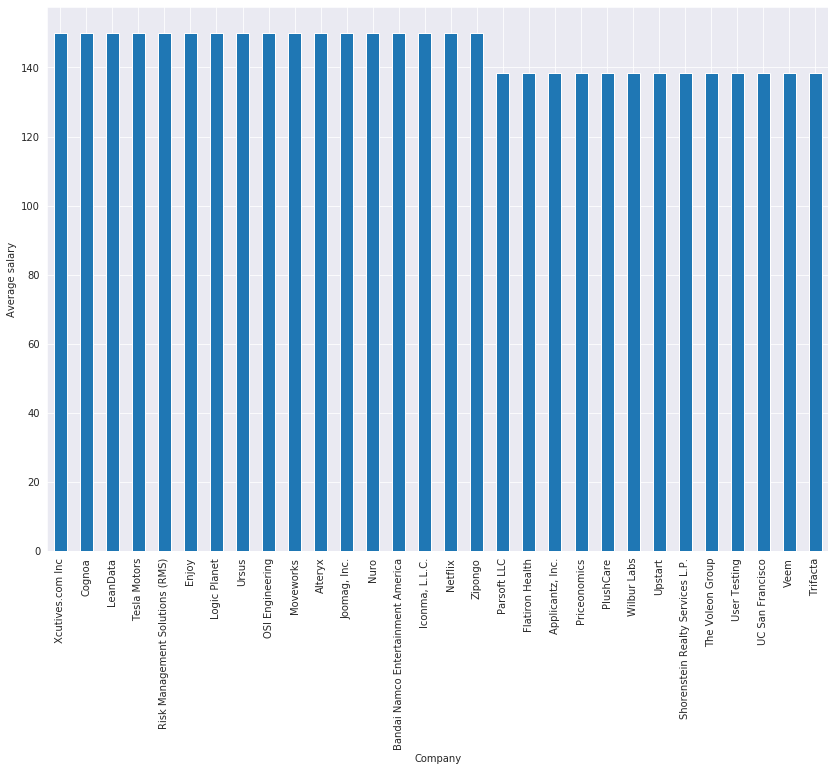

In [28]:
# plot top 30 companies with high average salaries
df.groupby('Company Name')['avg_salary'].mean().sort_values(ascending=False)[:30].plot(kind='bar', figsize=(14,10))
plt.xlabel('Company')
plt.ylabel('Average salary');

Let's study these companies closely.

In [29]:
# store top 30 companies offering high salaries in a list
top_30_comps = list(df.groupby('Company Name')['avg_salary'].mean().sort_values(ascending=False)[:30].index)

**How are the ratings of these companies?**

In [33]:
print("The rating is given on a scale {}-{}.".format(df['Rating'].min(), df['Rating'].max()))

The rating is given on a scale 1.0-5.0.


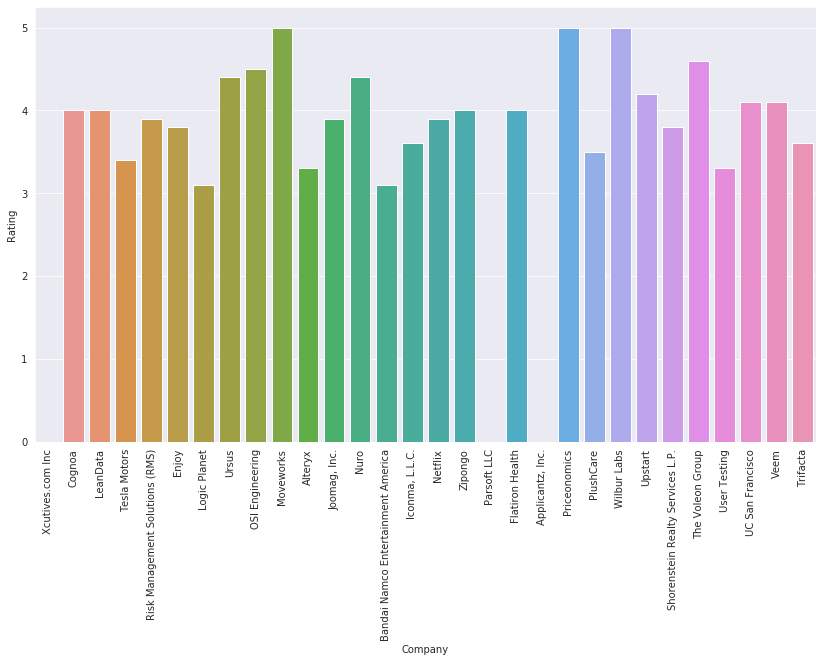

In [30]:
# plot ratings of these companies
plt.figure(figsize=(14,8))
sns.barplot(x=df[df['Company Name'].isin(top_30_comps)]['Company Name'], 
            y=df[df['Company Name'].isin(top_30_comps)]['Rating'],
            order = top_30_comps)
plt.xlabel('Company')
plt.xticks(rotation=90);

All the companies (except three) have a minimum rating value 3. 'Xcutives.com Inc', 'Applicantz, Inc' and 'Parsoft LLC' - although these three companies are offering high salaries to candidates, no rating is available for them. One reason might be that these are comparatively new companies.

**What about numbe of currently employed staffs in these companies?** The relevant feature for this question is 'Size'.

In [38]:
# unique values in the feature 'Size'
df['Size'].unique()

array(['201 to 500 employees', '10000+ employees',
       '1001 to 5000 employees', '501 to 1000 employees',
       '5001 to 10000 employees', '1 to 50 employees',
       '51 to 200 employees', nan], dtype=object)

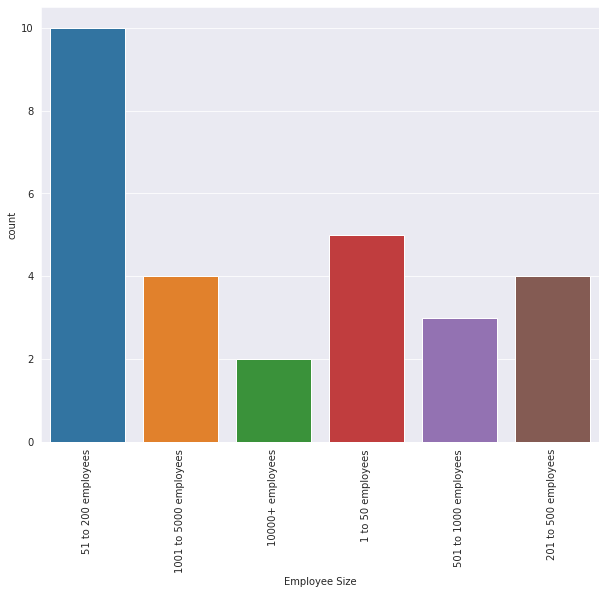

In [40]:
# Employee size of top 30 high paying companies
plt.figure(figsize=(10,8))
sns.countplot(df[df['Company Name'].isin(top_30_comps)]['Size'])   
plt.xlabel('Employee Size')
plt.xticks(rotation=90);

Surprisingly, most of the high paying companies are small in size. These are likely to be start-ups. So the data is telling us that start-ups are likely to pay more to data analysts as compared to big companies.

Another important question to explore could be **what are the financial status of these companies?** To find an answer to this, we look at the available feature 'Revenue'.

In [41]:
# unique values in 'Revenue'
df['Revenue'].unique()

array(['$100 to $500 million (USD)', '$2 to $5 billion (USD)', nan,
       '$50 to $100 million (USD)', '$1 to $2 billion (USD)',
       '$5 to $10 billion (USD)', '$1 to $5 million (USD)',
       '$25 to $50 million (USD)', '$10+ billion (USD)',
       'Less than $1 million (USD)', '$10 to $25 million (USD)',
       '$500 million to $1 billion (USD)', '$5 to $10 million (USD)'],
      dtype=object)

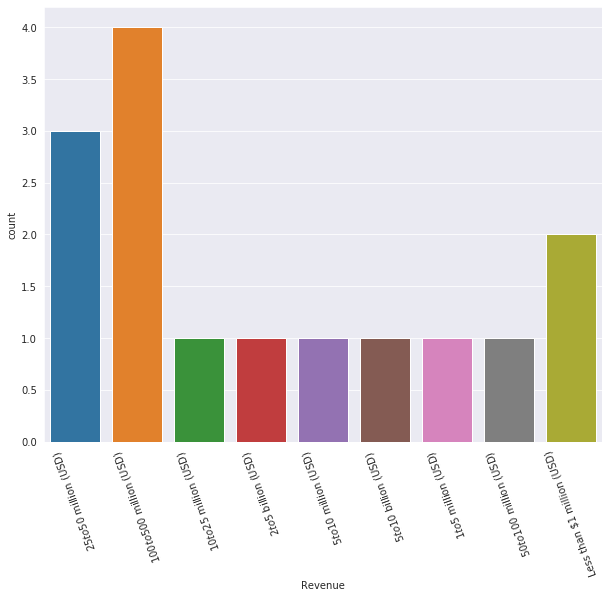

In [45]:
# plot revenues of top 30 high paying companies
plt.figure(figsize=(10,8))
sns.countplot(df[df['Company Name'].isin(top_30_comps)]['Revenue'])    
plt.xticks(rotation=110);

The plot reiterates the same thing - most of the data analyst job positions are available in companies of small and moderate sizes.

One more question in this chain - **where are these companies located?**

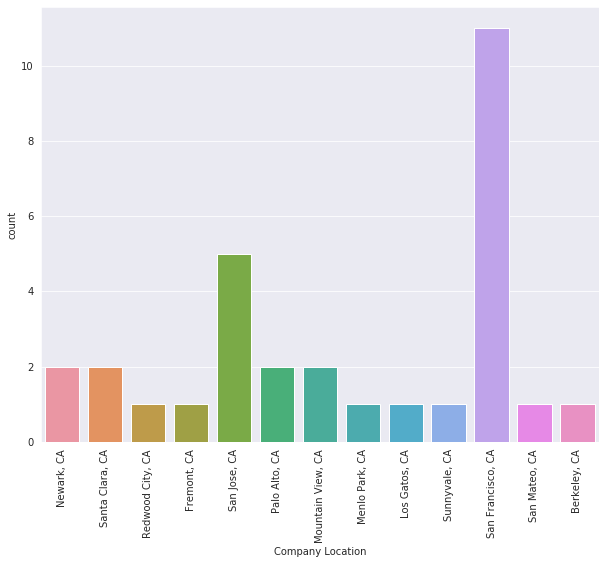

In [47]:
# plot locations of these top 30 companies
plt.figure(figsize=(10,8))
sns.countplot(df[df['Company Name'].isin(top_30_comps)]['Location'])    
plt.xlabel("Company Location")
plt.xticks(rotation=90);

All these companies are situated in CA! All the information that we gathered from this exercise can be summarized as follows:

**Companies offering high salaries to data analysts are small in size with average total revenue, generally have decent ratings and are situated in CA.** 

Next, we ask the following two questions:

- Do older companies pay more as compared to new ones?
- Where do we have high paying jobs?

Let's start with the first one. We can use the feature 'Founded' to compute the 'age' of a company.

In [48]:
current_year = datetime.datetime.now().year

# compute the age
df['Company_age'] = current_year - df['Founded']

# drop the original feature
df.drop('Founded', axis=1, inplace=True)

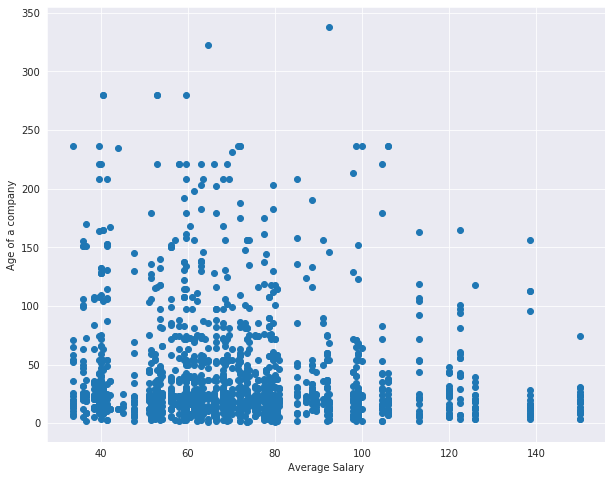

In [49]:
# plot avg. salary vs age of a company
plt.figure(figsize=(10,8))
plt.scatter(x='avg_salary', y='Company_age', data=df)
plt.xlabel('Average Salary')
plt.ylabel('Age of a company');

Therefore, we see that comparatively new companies pay more to data analysts than older companies.

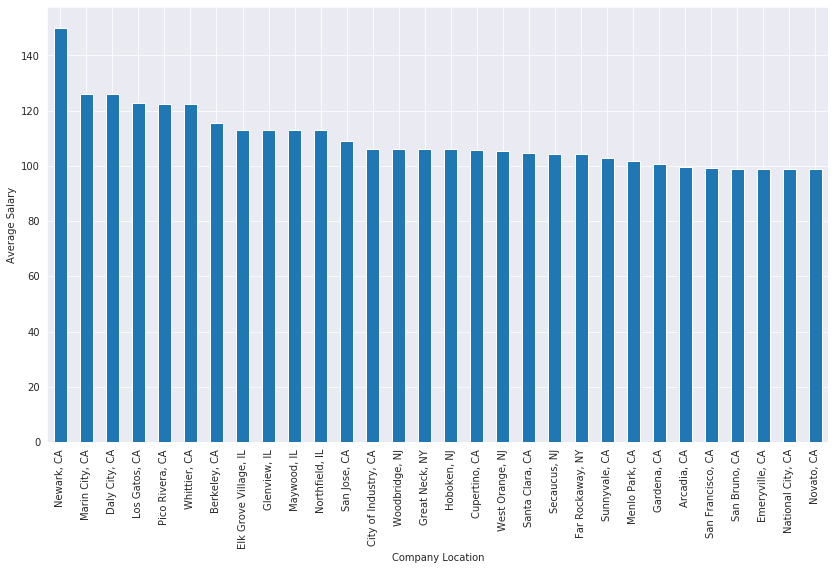

In [51]:
# plot top 30 locations offering high salaries to data analysts 
df.groupby('Location')['avg_salary'].mean().sort_values(ascending=False)[:30].plot(kind='bar', figsize=(14,8))
plt.xlabel('Company Location')
plt.ylabel('Average Salary');

Most of the high paying job positions are in CA. So, if you are looking for a career in data analytics, CA might be you next destination!

In [190]:
df.columns

Index(['Job Title', 'Job Description', 'Rating', 'Company Name', 'Location',
       'Headquarters', 'Size', 'Type of ownership', 'Industry', 'Sector',
       'Revenue', 'low_salary', 'up_salary', 'avg_salary', 'Company_age'],
      dtype='object')

In [4]:
description_text = df['Job Description']

In [5]:
description_text

0       Are you eager to roll up your sleeves and harn...
1       Overview\n\nProvides analytical and technical ...
2       We’re looking for a Senior Data Analyst who ha...
3       Requisition NumberRR-0001939\nRemote:Yes\nWe c...
4       ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...
                              ...                        
2248    Maintains systems to protect data from unautho...
2249    Position:\nSenior Data Analyst (Corporate Audi...
2250    Title: Technical Business Analyst (SQL, Data a...
2251    Summary\n\nResponsible for working cross-funct...
2252    You.\n\nYou bring your body, mind, heart and s...
Name: Job Description, Length: 2253, dtype: object

In [47]:
def text_to_word(text):

    word_list =  word_tokenize(re.sub(r"[^a-z]", " ", text.lower()))
    word_nostop_list = [word for word in word_list if word not in stopwords.words("english")]
    pos_dict = {"N":wordnet.NOUN, "J":wordnet.ADJ} # "V":wordnet.VERB, , , "R":wordnet.ADV
    
    lemm_token_list = set()
    for token,pos_tag in nltk.pos_tag(word_nostop_list):
        try:
            lemm_token_list.add(WordNetLemmatizer().lemmatize(token, pos=pos_dict[pos_tag[0]]))
        except:
            pass

    
    clean_text = ' '.join(lemm_token_list)
        
    return clean_text

In [48]:
df['cleaned_description'] = df['Job Description'].apply(lambda x:text_to_word(x))

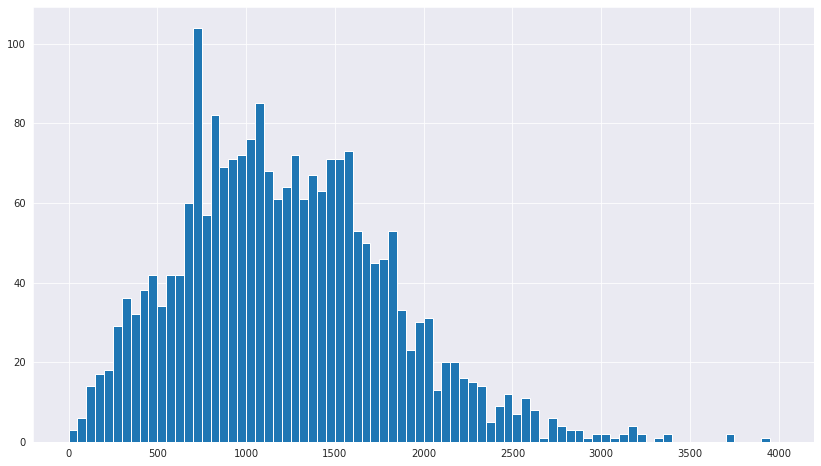

In [49]:
desc_len = [len(desc) for desc in df['cleaned_description']]
plt.figure(figsize=(14,8))
plt.hist(desc_len, bins=80, range=(0,4000));

In [30]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(background_color='white', max_words=500, max_font_size=40, 
                      random_state=22).generate(str(df['cleaned_description']))

(-0.5, 399.5, 199.5, -0.5)

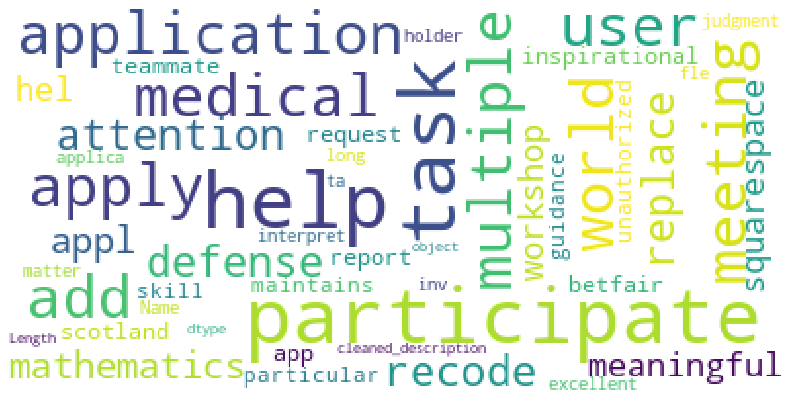

In [33]:
plt.figure(figsize=(14,8))
plt.imshow(wordcloud)
plt.axis("off")

In [50]:
count_vect = CountVectorizer(ngram_range=(1,1)).fit(df['cleaned_description'])
df_matrix = count_vect.transform(df['cleaned_description'])

In [44]:
df_matrix.shape

(2253, 10029)

In [33]:
sum_words = df_matrix.sum(axis=0)/df_matrix.shape[0]
sum_words

matrix([[0.01109632, 0.00044385, 0.00088771, ..., 0.00044385, 0.00044385,
         0.00133156]])

In [60]:
sum_words = df_matrix.sum(axis=0)
sum_words

matrix([[28,  1,  1, ...,  1,  1,  3]], dtype=int64)

In [12]:
count_vect.vocabulary_

{'part': 10104,
 'court': 3155,
 'parent': 10085,
 'step': 13262,
 'study': 13369,
 'initiative': 7084,
 'faxed': 5272,
 'monitor': 8997,
 'administers': 255,
 'policy': 10562,
 'partner': 10117,
 'affect': 332,
 'year': 15415,
 'vision': 14939,
 'address': 223,
 'st': 13155,
 'submission': 13390,
 'connect': 2891,
 'trend': 14284,
 'analyst': 592,
 'transformative': 14236,
 'leader': 7952,
 'disability': 3991,
 'immigration': 6815,
 'coordinate': 3055,
 'technical': 13783,
 'responsibility': 11843,
 'institute': 7154,
 'innovative': 7099,
 'extend': 5150,
 'basis': 1288,
 'stakeholder': 13175,
 'analysis': 579,
 'globally': 5954,
 'sex': 12550,
 'independent': 6946,
 'recur': 11468,
 'close': 2458,
 'evidence': 4979,
 'effort': 4481,
 'eager': 4347,
 'www': 15372,
 'modify': 8962,
 'youll': 15451,
 'use': 14707,
 'enthusiasm': 4746,
 'list': 8142,
 'engineer': 4694,
 'harness': 6249,
 'program': 10929,
 'military': 8843,
 'center': 2155,
 'universal': 14582,
 'support': 13523,
 'emplo

In [51]:
# get top 10 unigrams

def top_n_unigram(document, n):
    
    count_vect = CountVectorizer(ngram_range=(1,1))
    dt_matrix = count_vect.fit_transform(document)
    
    word_freq = dt_matrix.sum(axis=0)/df_matrix.shape[0]
    word_freq_list = [(word, word_freq[0, index]) for word, index in count_vect.vocabulary_.items()]
    word_freq_list = sorted(word_freq_list, key=lambda x:x[1], reverse=True)
    
    return word_freq_list[:n]

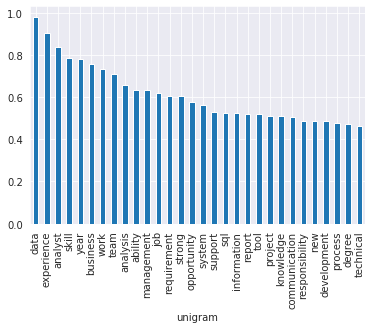

In [52]:
top_unigrams = top_n_unigram(df['cleaned_description'], 30)
df2 = pd.DataFrame(top_unigrams, columns = ['unigram' , 'count'])
df2.set_index('unigram', inplace=True)
df2['count'].plot(kind='bar')

In [53]:
lda = LatentDirichletAllocation()
new_mat = lda.fit_transform(df_matrix)

In [37]:
new_mat.shape

(2253, 10)

In [26]:
#lda.components_

In [54]:
keywords = np.array(count_vect.get_feature_names())

In [26]:
keywords.shape

(15506,)

In [55]:
topic_keywords = []

for topic_weights in lda.components_:
    top_keyword_locs = (-topic_weights).argsort()[:5]
    topic_keywords.append(keywords.take(top_keyword_locs))
    
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords

,0,1,2,3,4
0,data,experience,year,analysis,benefit
1,service,data,year,analyst,business
2,data,analyst,experience,skill,year
3,data,job,support,analyst,experience
4,race,sexual,origin,orientation,disability
5,year,member,team,analyst,responsibility
6,data,report,experience,year,system
7,data,experience,analyst,business,team
8,team,year,data,work,experience
9,data,experience,business,skill,strong


In [61]:
df['Location'] = df['Location'].apply(lambda x:x.split(",")[1])
df['Location']

0        NY
1        NY
2        NY
3        NY
4        NY
       ... 
2248     CO
2249     CO
2250     CO
2251     CO
2252     CO
Name: Location, Length: 2253, dtype: object

In [62]:
df['Location'].unique()

array([' NY', ' NJ', ' UT', ' CA', ' VA', ' FL', ' IL', ' TX', ' AZ',
       ' PA', ' DE', ' OH', ' NC', ' SC', ' IN', ' WA', ' GA', ' KS',
       ' CO', ' Arapahoe'], dtype=object)